In [1]:
import itertools
from collections import Counter
import pandas as pd
import numpy as np
from pymatgen.core import Element, Composition
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

rcparams = {'legend.fontsize': 20,
            'figure.figsize': (12, 8),
            'axes.labelsize': 24,
            'axes.titlesize': 28,
            'xtick.labelsize':20,
            'ytick.labelsize': 20}
mpl.rcParams.update(rcparams)

%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [2]:
orig_data = pd.read_csv("data.csv", na_filter=False)

In [3]:
elements = []
for i in orig_data['formula']:
    elements.append(Composition(i).elements)

orig_data["elements"] = elements

unique = set(itertools.chain(*elements))

print("There are %d elements." % len(unique))

There are 89 elements.


In [4]:
nelements = [len(l) for l in elements]
max_els = max(nelements)
print("Maximum number of elements in a structure is %d" % max_els)

Maximum number of elements in a structure is 9


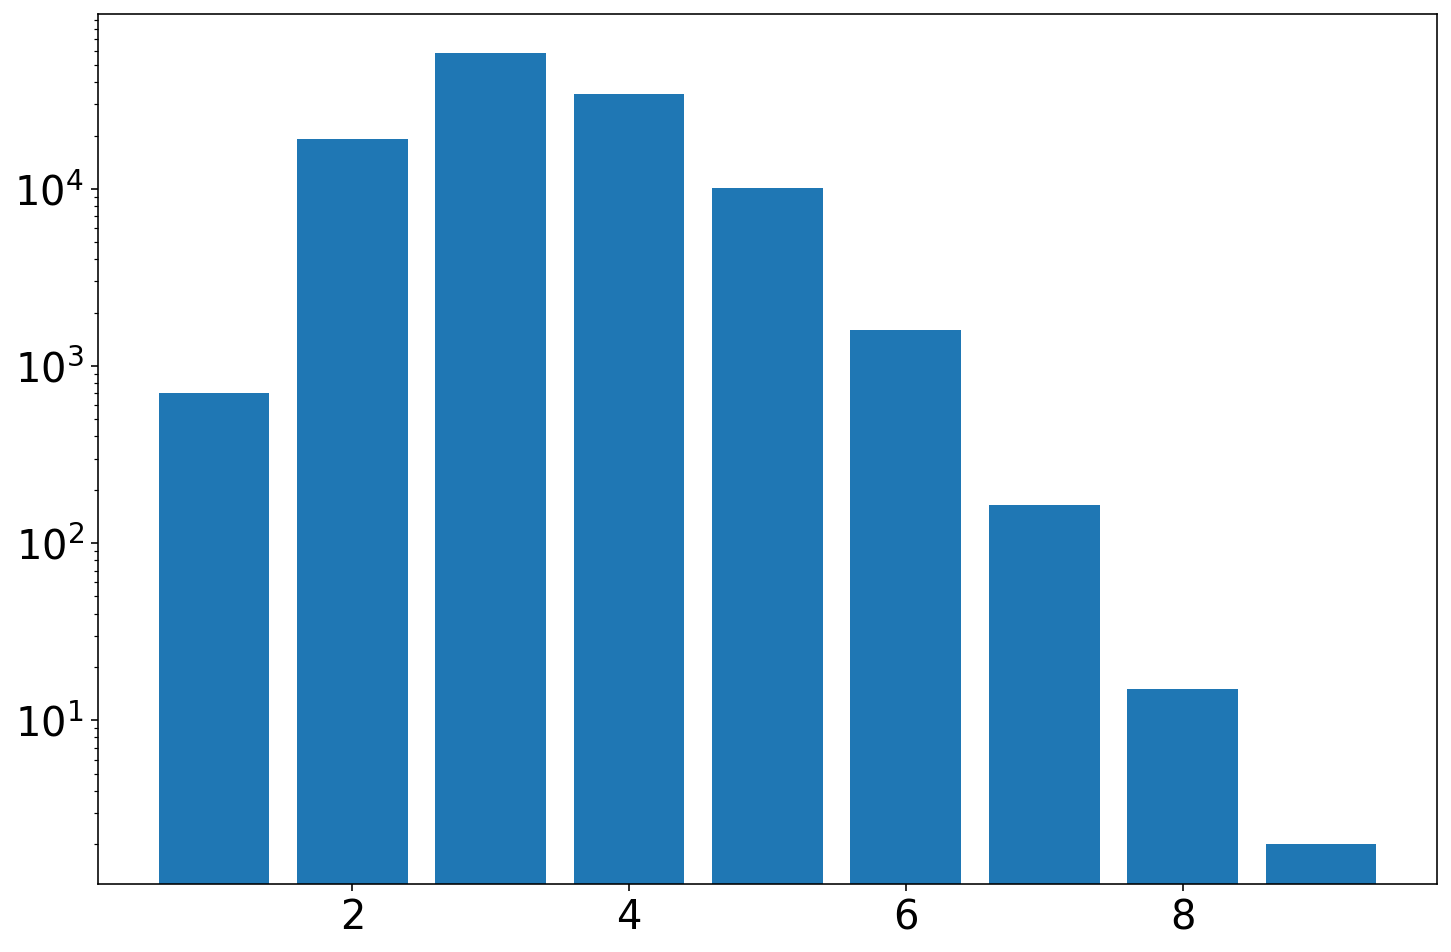

In [5]:
import collections
el_count = collections.Counter(nelements)
fig, ax = plt.subplots(figsize=(12, 8))
plt.bar(range(1, max_els+1), [el_count[i] for i in range(1, max_els+1)])
plt.yscale('log')

In [6]:
el_count = Counter(itertools.chain(*elements))
counts = sorted(el_count.items(), key=lambda k: k[1])
print('Top 10 most common elements are ')
print(counts[-10:][::-1])
print('Top 10 least common elements are ')
print(counts[:10])

Top 10 most common elements are 
[(Element O, 60428), (Element Li, 18580), (Element P, 13321), (Element Mn, 11233), (Element S, 10516), (Element Fe, 10109), (Element N, 9723), (Element F, 9606), (Element Si, 8940), (Element Mg, 8711)]
Top 10 least common elements are 
[(Element Ne, 1), (Element Ar, 2), (Element He, 8), (Element Kr, 15), (Element Xe, 147), (Element Pa, 253), (Element Ac, 297), (Element Np, 340), (Element Pu, 388), (Element Pm, 515)]


In [7]:
elements_temp = [Element.from_Z(i) for i in range(1, 95)]
noble_gases = [i for i in elements_temp if i.is_noble_gas]

def is_contain_noble_gas(elements):
    return any([i in noble_gases for i in elements])

not_contain_noble_gas = [not is_contain_noble_gas(i) for i in orig_data['elements']]

data = orig_data.copy()
data = data[not_contain_noble_gas]
print("The remaining number of materials is %d" % data.shape[0])

The remaining number of materials is 124342


In [8]:
element_data = pd.read_csv('element_properties.csv', index_col=0)

In [9]:
mean_columns = element_data.mean(skipna=True)

In [10]:
element_data = element_data.fillna(mean_columns)

In [11]:
data['composition'] = [Composition(i).to_data_dict['unit_cell_composition'] for i in data['formula']]

In [12]:
data['composition'][0]

defaultdict(float, {'Cr': 1.0, 'Ni': 3.0})

In [13]:
c = {'Cr': 1.0, 'Ni': 3.0}

In [14]:
isinstance(c, dict)

True

In [15]:
unit_cell_composition = c

In [16]:
prop = 'AtomicRadius'
res = 0
total = 0
unit_cell_composition.items()

dict_items([('Cr', 1.0), ('Ni', 3.0)])

In [17]:
(element_data.loc['Cr', prop] * 1 + element_data.loc['Ni', prop] * 3) / (1+3)

1.3625000000000003

In [18]:
def average_radius(c, prop):
    unit_cell_composition = c
    numerator = 0
    denominator = 0
    for elem, fraction in unit_cell_composition.items():
        numerator += element_data.loc[elem, prop] * fraction
        denominator += fraction
    return numerator / denominator

atomic_radius = [compute_average_from_composition(i, 'AtomicRadius') for i in data['composition']]

atomic_radius

NameError: name 'compute_average_from_composition' is not defined

In [ ]:
def composition_to_dict(c):
    if isinstance(c, dict):
        unit_cell_composition = c
    else:
        if isinstance(c, str):
            c = Composition(c)
        unit_cell_composition = c.to_data_dict['unit_cell_composition']
    return unit_cell_composition

def compute_average_from_composition(c, prop):
    unit_cell_composition = composition_to_dict(c)
    res = 0
    total = 0
    for i, j in unit_cell_composition.items():
        res += element_data.loc[i, prop] * j
        total += j
    return res / total

def get_maxmin_properties(c, prop, mode='max'):
    if mode == 'max':
        func = np.max
    elif mode == "min":
        func = np.min
        
    unit_cell_composition = composition_to_dict(c)
    res = func([element_data.loc[i, prop] for i in unit_cell_composition])
    return res

In [ ]:
atomic_radius = [compute_average_from_composition(i, 'AtomicRadius') for i in data['composition']]
atomic_radius

In [ ]:
properties = element_data.columns
average_properties = []
for prop in properties:
    average_properties.append([compute_average_from_composition(i, prop) for i in data['composition']])

In [ ]:
properties

In [ ]:
average_properties = np.array(average_properties).T
average_properties

In [ ]:
max_properties = []
min_properties = []
for prop in properties:
    max_properties.append([get_maxmin_properties(i, prop, mode='max') for i in data['composition']])
    min_properties.append([get_maxmin_properties(i, prop, mode='min') for i in data['composition']])
    
max_properties = np.array(max_properties).T
min_properties = np.array(min_properties).T

In [ ]:
design_matrix = np.concatenate([average_properties, max_properties, min_properties], axis=1)

In [ ]:
np.max([element_data.loc[i, prop]])